# Ciclope voxel uFE pipeline @ JCW_2022
From micro-CT image to voxel-uFE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 22.06.2022 <br />

- Data source: LHDL project (IOR Bologna, Italy. For info on the dataset see [here](http://projects.kmi.open.ac.uk/lhdl/) )

---
![FE pipeline](fem_pipeline.png)
The example implements the following ciclope pipeline:
- [X] Load and inspect microCT volume data
- [X] Image preprocessing
    - [X] Apply Gaussian smooth (optional)
    - [X] Resample the dataset (optional)
    - [x] Segment bone tissue
    - [x] Remove unconnected clusters of voxels
- [x] Generate 3D Unstructured Grid voxel of hexahedra (voxels)
- [x] Generate voxel-FE model for simulation in CalculX or Abaqus from 3D voxel mesh 
    - [x] Linear, static analysis definition: uniaxial compression test
- [x] Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
- [x] Convert Calculix output to .VTK for visualization in Paraview
- [X] Calculate apparent elastic modulus from reaction forces

---
### Notes on ciclope
* All mesh exports are performed with the [meshio](https://github.com/nschloe/meshio) module.
* **ciclope** handles the definition of material properties and FE analysis parameters (e.g. boundary conditions, simulation steps..) through separate template files. The folders [material_properties](https://github.com/gianthk/ciclope/tree/master/material_properties) and [input_templates](https://github.com/gianthk/ciclope/tree/master/input_templates) contain a library of template files that can be used to generate FE simulations.
  * Additional libraries of [CalculiX](https://github.com/calculix) examples and template files can be found [here](https://github.com/calculix/examples) and [here](https://github.com/calculix/mkraska)
___

### Command line execution
The pipeline described in this notebook can be executed from the command line using the **ciclope** command: <br />

```commandline
python ciclope.py test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE.inp -vs 0.0195 0.0195 0.0195 -r 2 -t 63 --smooth 1 --voxelfe --template input_templates/tmp_example01_comp_static_bone.inp
```


Type `python ciclope.py -h` to display the ciclope help with a full list of available command line arguments.

## Configuration

In [1]:
import sys
sys.path.append('./../')

In [6]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes
import ciclope

In [9]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Load input data

In [4]:
input_file = './../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Voxel size|19.5 micron|
|Preliminary operations|Cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [7]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

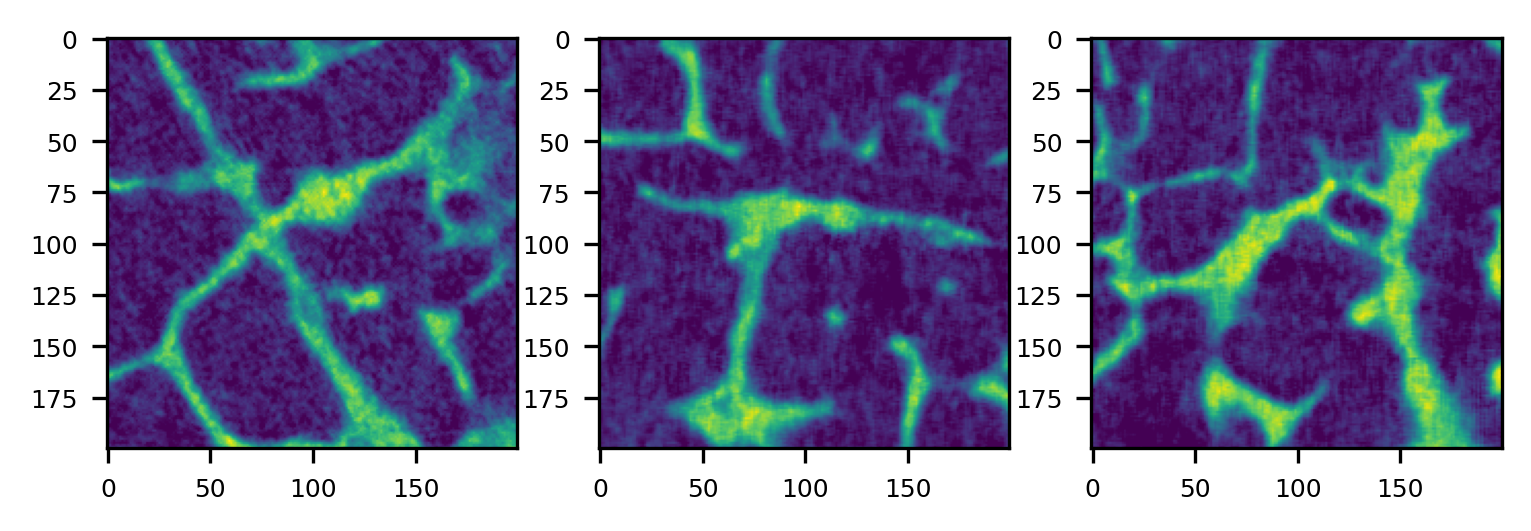

In [10]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [8]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [9]:
# launch itk viewer
viewer

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

## Pre-processing
### Gaussian smooth

In [11]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (downsample) with factor 2

In [12]:
resampling = 2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [11]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding


In [13]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.72472439570987


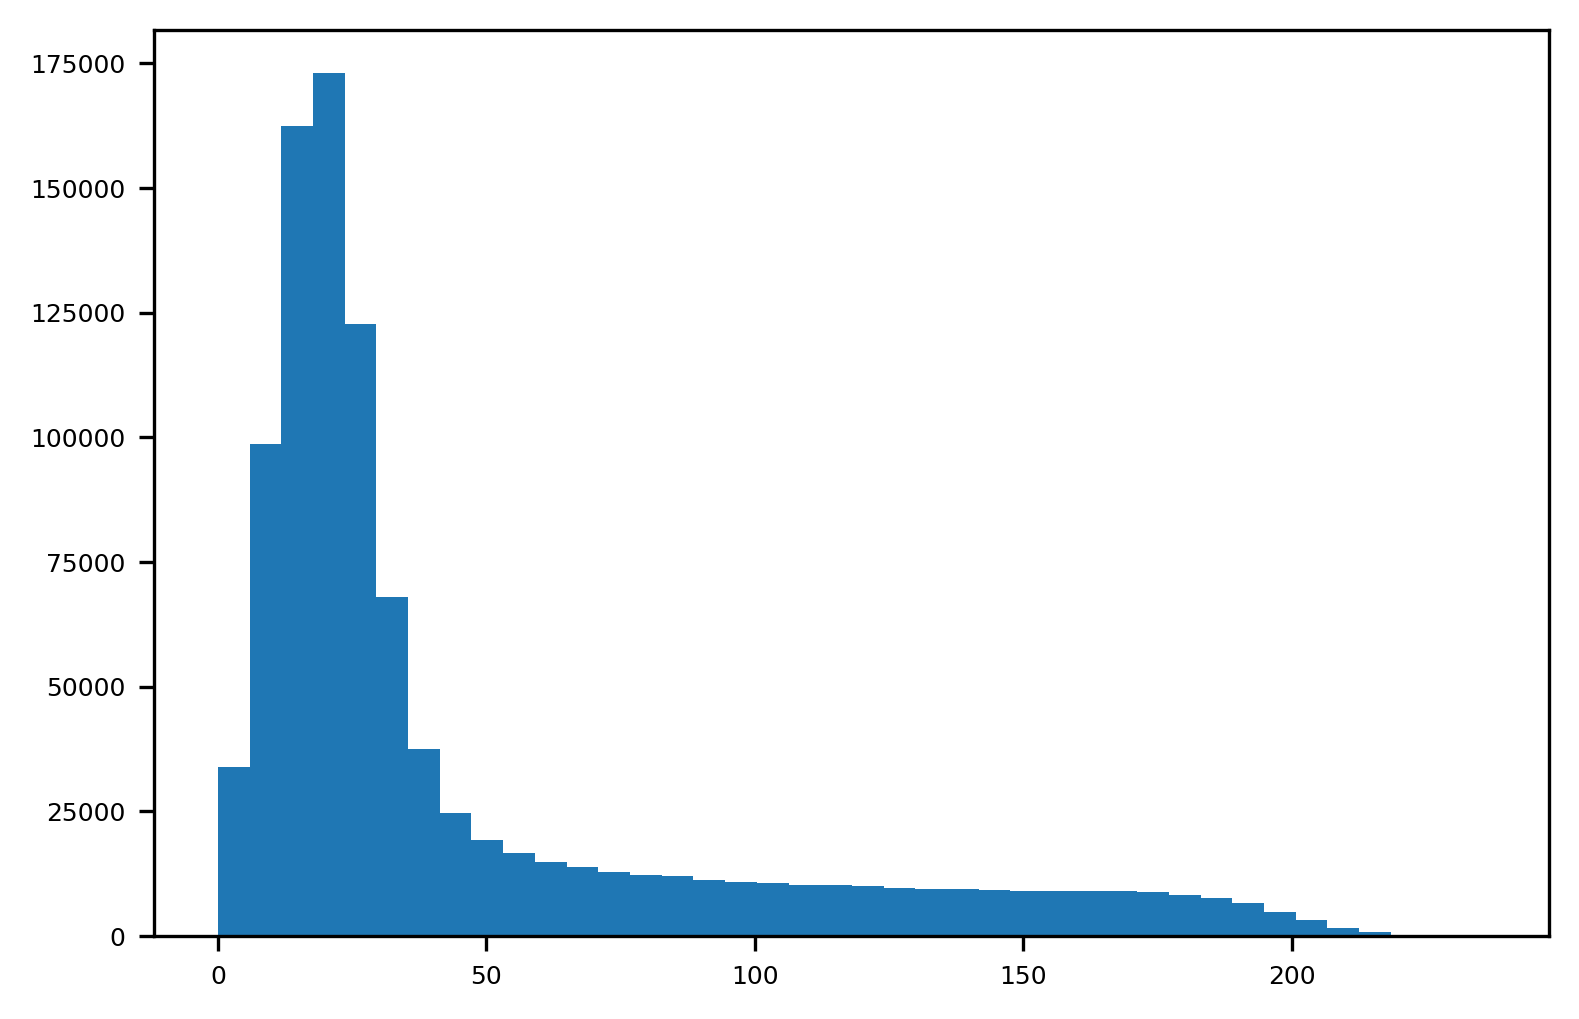

In [13]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply single global threshold obtained from comparison with histology

In [14]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

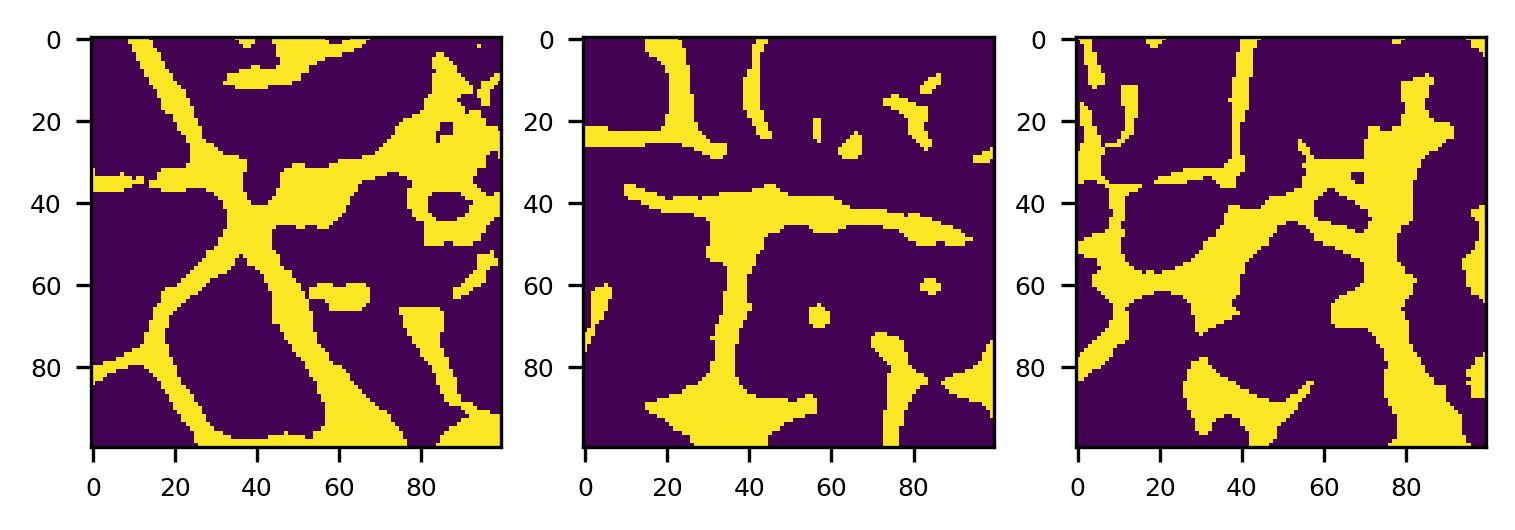

In [15]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [15]:
BW = morphology.closing(BW, morphology.ball(3))

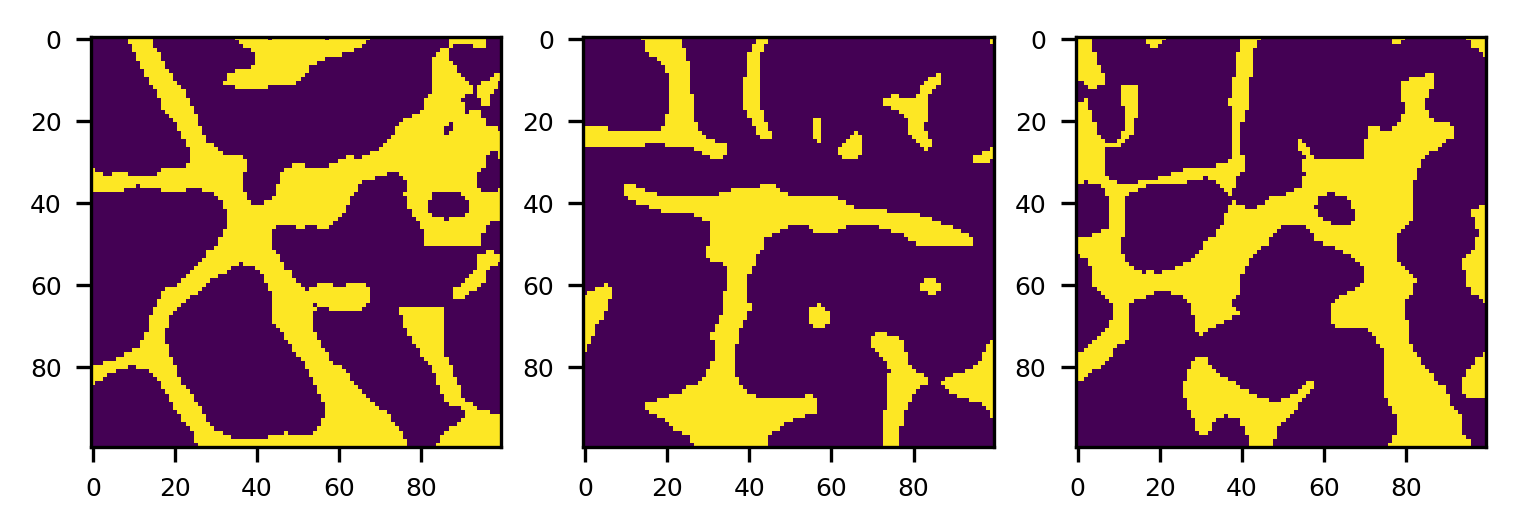

In [17]:
plot_midplanes(BW)
plt.show()

### Crop a small portion (for checking)

In [18]:
# BW = BW[50:100 ,50:100, 50:100]

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [19]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [20]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [21]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in the ciclope module **pybonemorph**

In [16]:
from ciclope.utils.pybonemorph import remove_unconnected

In [17]:
L = remove_unconnected(BW)

Inspect dataset

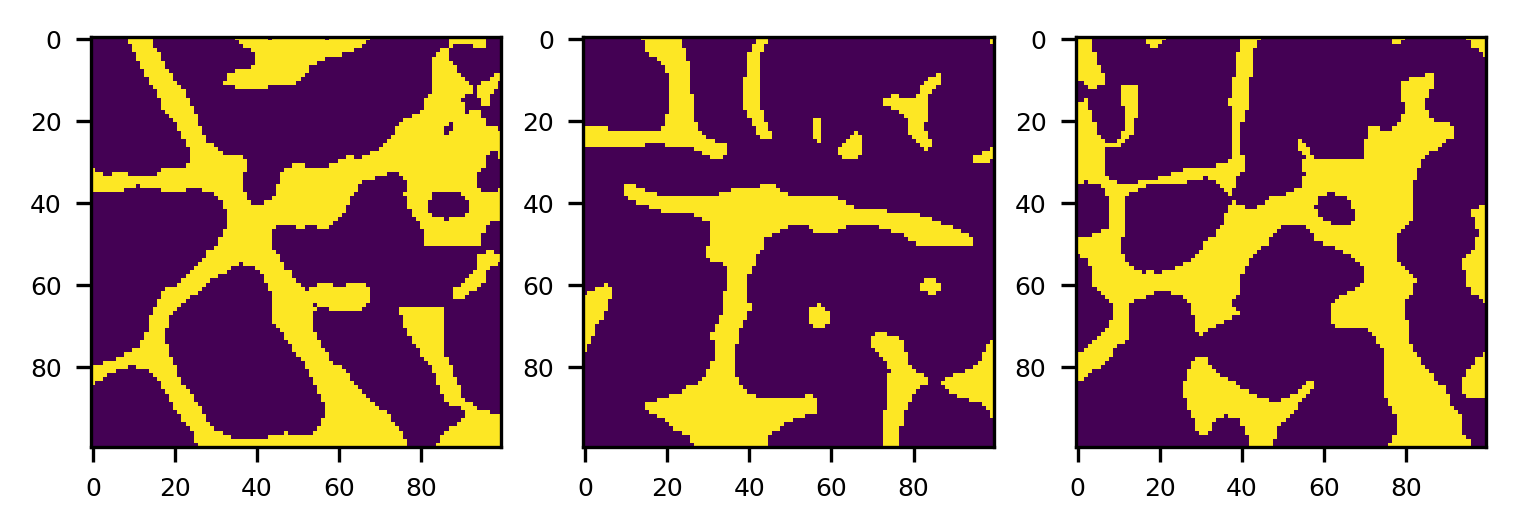

In [24]:
plot_midplanes(L)
plt.show()

## Generate Unstructured Grid Mesh of hexahedra from volume data

In [18]:
mesh = ciclope.voxelFE.vol2ugrid(L, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 1030301 nodes and 247062 elements:
INFO:root:<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247062
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


#### Write the mesh using `meshio`:
Support for binary data type is not included. We cast GV cell_data to `uint8` 

In [19]:
mesh.cell_data['GV'] = mesh.cell_data['GV'][0].astype('uint8')

In [15]:
print(mesh)

<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247062
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


In [13]:
filename_mesh_out = './../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelmesh.vtk'

In [14]:
mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [8]:
import vtk
import itk
from itkwidgets import view

In [9]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_mesh_out)
reader.Update()
grid = reader.GetOutput()

In [10]:
view(geometries=grid)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

![LHDL voxel mesh](./../test_data/LHDL/3155_D_4_bc/results/LHDL_voxelFE.png)

## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.6/books/usb/default.htm?startat=pt05ch17s02abm02.html

In [20]:
filename_out = './../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE.inp'

In [21]:
input_template = "./../input_templates/tmp_example01_comp_static_bone.inp"

In [22]:
!cat {input_template} # on linux
# !type ".\..\input_templates\tmp_example01_comp_static_bone.inp # on Win

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


In [23]:
ciclope.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True)

INFO:root:Found cell_data: GV. cell_data range: 1 - 1.
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../input_templates/tmp_example01_comp_static_bone.inp
INFO:root:Model with 1030301 nodes and 247062 elements written to file ./../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [17]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:      1030249
   elements:       247062
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:        11787
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [20]:
import os
import ccx2paraview

In [21]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading 3155_D_4_bc_voxelFE.frd
INFO:root:324290 nodes
INFO:root:233409 cells
INFO:root:Step 1, time 1.0, U, 3 components, 324290 values
INFO:root:Step 1, time 1.0, S, 6 components, 324290 values
INFO:root:Step 1, time 1.0, E, 6 components, 324290 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 324290 values
INFO:root:1 time increment
INFO:root:Writing 3155_D_4_bc_voxelFE.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 324290 values
INFO:root:Step 1, time 1.0, S, 6 components, 324290 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 324290 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 324290 values
INFO:root:Step 1, time 1.0, E, 6 components, 324290 values
INFO:root:Step 1, time 1.0, E_Mises, 1 components, 324290 values
INFO:root:Step 1, time 1.0, E_Principal, 3 components, 324290 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 324290 values


### Reaction forces

In [20]:
!cat {filename_out_base+'.dat'}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

       -1.690709E-11  7.061157E-13  2.473045E+02


### Apparent elastic modulus

In [23]:
E = 2.47e2/0.04
print(f"{E:.2f} MPa")

6175.00 MPa


Bone volume fraction

In [24]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f} %")

24.71 %


#### Visualize results in Paraview

In [26]:
!paraview {filename_out_base + '.vtk'}

![U3_displacements](./../test_data/LHDL/3155_D_4_bc/results/LHDL_voxelFE_U3.png)

Visuailzation with itkwidgtes (does not show field data..)

In [ ]:
import vtk

In [ ]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_vtk)
reader.Update()
grid = reader.GetOutput()

In [ ]:
view(geometries=grid)

---
# Heterogeneous material mapping
Description here

#### Mask the dataset

In [19]:
masked = data_3D.copy().astype('uint8')

In [21]:
masked[~L] = 0

In [88]:
plot_midplanes(masked)

### Generate Unstructured Grid Mesh of hexahedra from volume data

In [89]:
mesh = ciclope.voxelFE.vol2ugrid(masked, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 1030301 nodes and 247062 elements:
INFO:root:<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247062
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


In [90]:
print(mesh.cell_data)

{'GV': [array([ 14,  19,  24, ..., 186, 149,  96], dtype=uint8)]}


Write the mesh for checking using `meshio`

In [18]:
# filename_mesh_out = './../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelmesh.vtk'
# mesh.write(filename_mesh_out)

## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.6/books/usb/default.htm?startat=pt05ch17s02abm02.html

In [92]:
filename_out = './../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_matprop_voxelFE.inp'

In [91]:
input_template = "./../input_templates/tmp_example01_comp_static_bone_matprop.inp"

In [93]:
!cat {input_template}

** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.02
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S
*END STEP


Material law in use

In [22]:
E_max = 18e3
GV_max = np.max(masked)

In [23]:
E_tissue = E_max*((masked[masked>0])/GV_max)**2.5

In [24]:
E_tissue = E_max*((masked[masked>0])/GV_max)

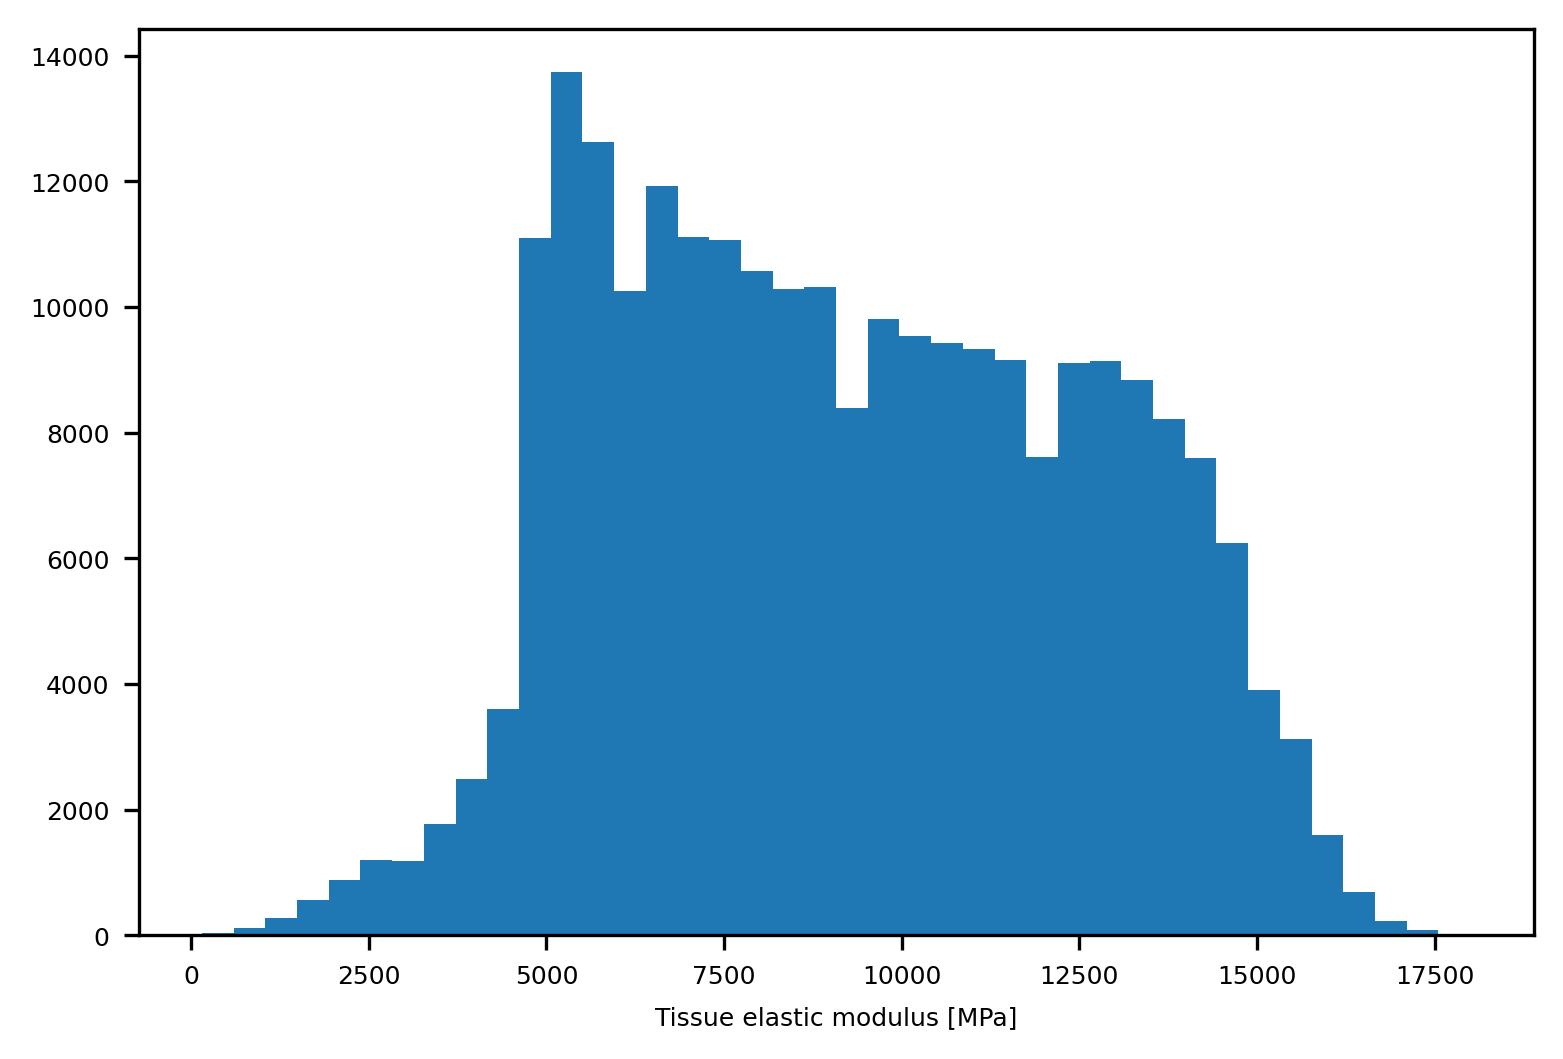

In [30]:
# plot the input image histogram
fig3, ax3 = plt.subplots()
plt.hist(E_tissue.ravel(), bins=40)
plt.xlabel('Tissue elastic modulus [MPa]')
plt.show()

In [123]:
ciclope.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True,
                             matprop = {
                                 "file": ["./../material_properties/bone_Elinear.inp"],
                                 "range": [[1, 250]]
                                       })

INFO:root:Found cell_data: GV. cell_data range: 2 - 236.
INFO:root:Checking GV range for user material properties
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../../input_templates/tmp_example01_comp_static_bone_matprop.inp
INFO:root:Model with 1030301 nodes and 247062 elements written to file ./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_matprop_voxelFE.inp


Run in CalculiX

In [124]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_matprop_voxelFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:      1030249
   elements:       247062
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:        11787
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

        to element          108
 *ERROR in calinput: no material was assigned
        to element          109
 *ERROR in calinput: no material was assigned
        to element          110
 *ERROR in calinput: no material was assigned
        to element          111
 *ERROR in calinput: no material was assigned
        to element          112
 *ERROR in calinput: no material was assigned
        to element          113
 *ERROR in calinput: no material was assigned
        to element          114
 *ERROR in calinput: no material was assigned
        to element          115
 *ERROR in calinput: no material was assigned
        to element          116
 *ERROR in calinput: no material was assigned
        to element          117
 *ERROR in calinput: no material was assigned
        to element          118
 *ERROR in calinput: no material was assigned
        to element          119
 *ERROR in calinput: no material was assigned
        to element          120
 *ERROR in calinput: no material

 *ERROR in calinput: no material was assigned
        to element         7148
 *ERROR in calinput: no material was assigned
        to element         7149
 *ERROR in calinput: no material was assigned
        to element         7150
 *ERROR in calinput: no material was assigned
        to element         7151
 *ERROR in calinput: no material was assigned
        to element         7152
 *ERROR in calinput: no material was assigned
        to element         7153
 *ERROR in calinput: no material was assigned
        to element         7154
 *ERROR in calinput: no material was assigned
        to element         7155
 *ERROR in calinput: no material was assigned
        to element         7156
 *ERROR in calinput: no material was assigned
        to element         7157
 *ERROR in calinput: no material was assigned
        to element         7158
 *ERROR in calinput: no material was assigned
        to element         7159
 *ERROR in calinput: no material was assigned
        to element

 *ERROR in calinput: no material was assigned
        to element        14494
 *ERROR in calinput: no material was assigned
        to element        14495
 *ERROR in calinput: no material was assigned
        to element        14496
 *ERROR in calinput: no material was assigned
        to element        14497
 *ERROR in calinput: no material was assigned
        to element        14498
 *ERROR in calinput: no material was assigned
        to element        14499
 *ERROR in calinput: no material was assigned
        to element        14500
 *ERROR in calinput: no material was assigned
        to element        14501
 *ERROR in calinput: no material was assigned
        to element        14502
 *ERROR in calinput: no material was assigned
        to element        14503
 *ERROR in calinput: no material was assigned
        to element        14504
 *ERROR in calinput: no material was assigned
        to element        14505
 *ERROR in calinput: no material was assigned
        to element

 *ERROR in calinput: no material was assigned
        to element        21635
 *ERROR in calinput: no material was assigned
        to element        21636
 *ERROR in calinput: no material was assigned
        to element        21637
 *ERROR in calinput: no material was assigned
        to element        21638
 *ERROR in calinput: no material was assigned
        to element        21639
 *ERROR in calinput: no material was assigned
        to element        21640
 *ERROR in calinput: no material was assigned
        to element        21641
 *ERROR in calinput: no material was assigned
        to element        21642
 *ERROR in calinput: no material was assigned
        to element        21643
 *ERROR in calinput: no material was assigned
        to element        21644
 *ERROR in calinput: no material was assigned
        to element        21645
 *ERROR in calinput: no material was assigned
        to element        21646
 *ERROR in calinput: no material was assigned
        to element

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Material law in use

In [116]:
E_max = 18e3
GV_max = np.max(masked)

In [112]:
E_tissue = E_max*((masked[masked>0])/GV_max)**2.5

In [117]:
E_tissue = E_max*((masked[masked>0])/GV_max)

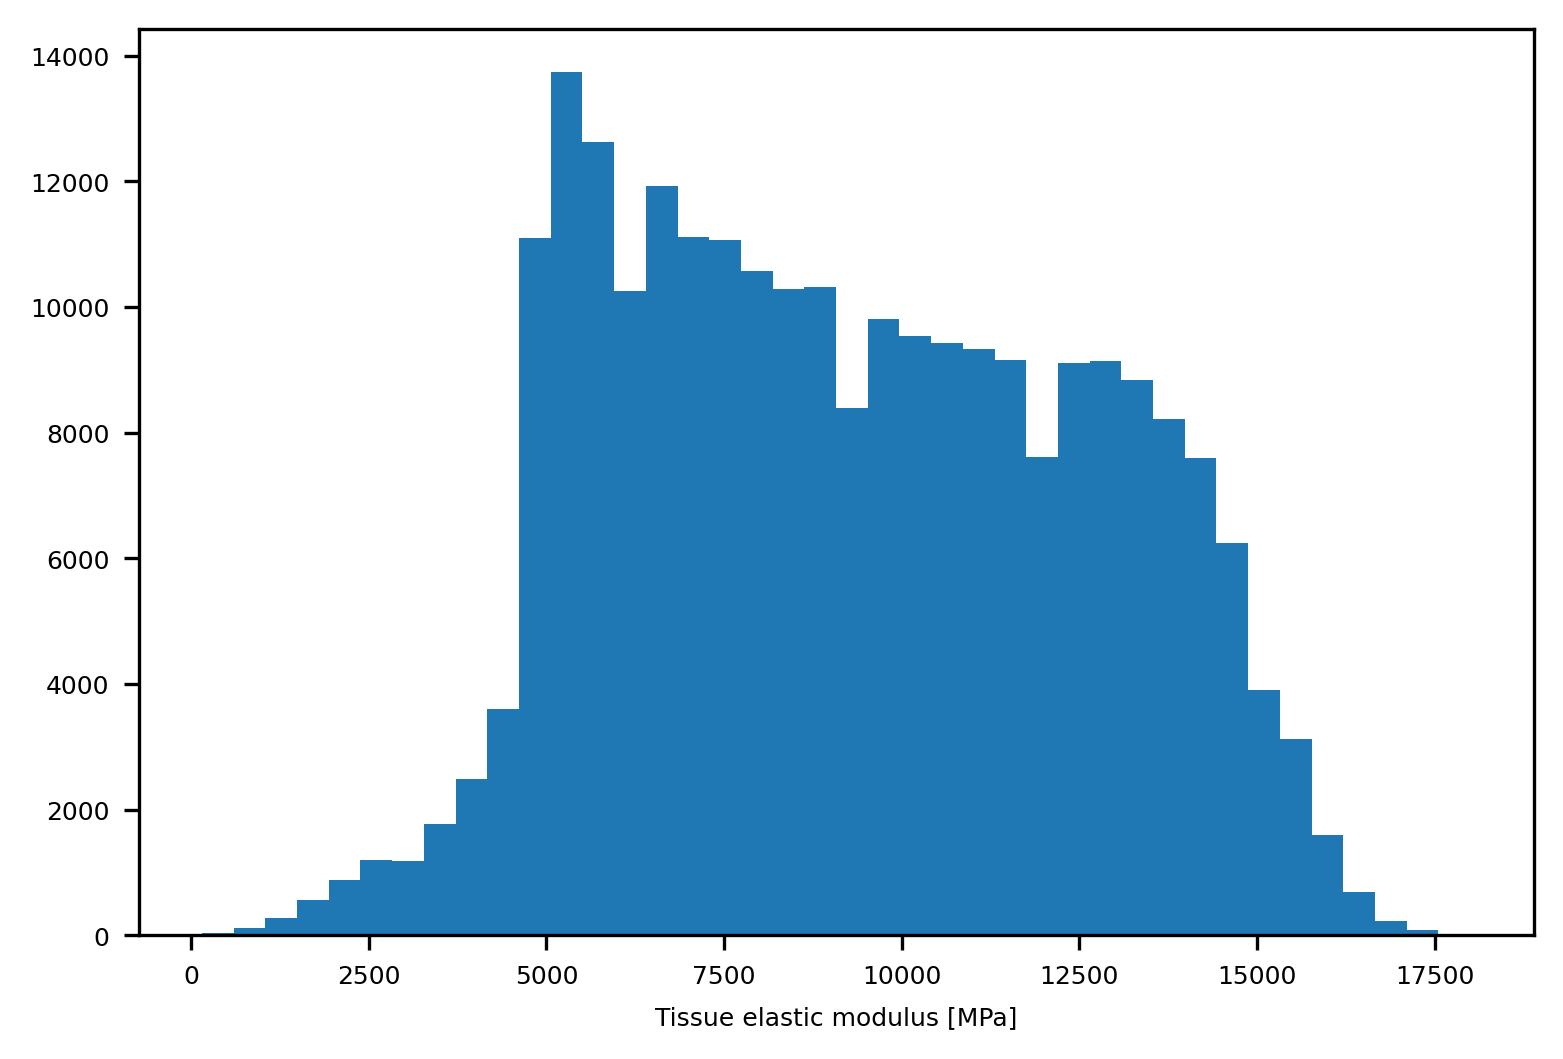

In [121]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(E_tissue.ravel(), bins=40)
plt.xlabel('Tissue elastic modulus [MPa]')
plt.show()